<a href="https://colab.research.google.com/github/Cartesian1671/IRTM-KEN-4153/blob/main/Copy_of_02_4_IRTM_Tutorial_reranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining 2023
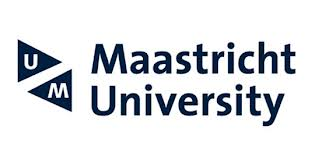
## Tutorial 2 - Notebook 4

In this notebook, we will finetune and evaluate BERT for re-ranking on [MS MACRO](https://huggingface.co/datasets/ms_marco) dataset. We will be using HuggingFace to finetune the model, which makes it easy to plug in any pretrained model on HF Hub that can be used for sequence and classification. The model will be finetuned to output a score between 0 and 1 when given a pair of query and passage. You can check the [original paper](https://arxiv.org/abs/1901.04085) for more details.

In [ ]:
!pip install -q transformers datasets

In [ ]:
from datasets import Dataset, load_dataset
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import pandas as pd

We start by loading the dataset.

In [ ]:
dataset = load_dataset('ms_marco', 'v1.1')
dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

We convert the each set to a Pandas DataFrame to make it easier to handle the data.

In [ ]:
original_train_df = dataset['train'].to_pandas()
original_validation_df = dataset['validation'].to_pandas()
original_test_df = dataset['test'].to_pandas()

len(original_train_df), len(original_validation_df), len(original_test_df)

(82326, 10047, 9650)

In [ ]:
original_validation_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,"[Approximately $15,000 per year.]","{'is_selected': [1, 0, 0, 0, 0, 0], 'passage_t...",walgreens store sales average,9652,numeric,[]
1,"[$21,550 per year, The average hourly wage for...","{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0], 'pas...",how much do bartenders make,9653,numeric,[]
2,"[A boil, also called a furuncle, is a deep fol...","{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0], 'pas...",what is a furuncle boil,9654,description,[]
3,"[Detect and assess a wide range of disorders, ...","{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0], '...",what can urinalysis detect,9655,description,[]
4,"[Shigellosis, diseases of the nervous system, ...","{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0], '...",what is vitamin a used for,9656,description,[]


We sample 10% of each set because training on the whole dataset will take a lot of time.

In [ ]:
train_df = original_train_df.sample(frac=0.1).reset_index(drop=True)
validation_df = original_validation_df.sample(frac=0.1).reset_index(drop=True)
test_df = original_test_df.sample(frac=0.1).reset_index(drop=True)

len(train_df), len(validation_df), len(test_df)

(8233, 1005, 965)

If you check passages column, you can see it contains a dictionary with keys and values. We will split that dictionary into multiple columns with keys as the column names. 

In [ ]:
train_df = pd.concat([train_df, pd.json_normalize(train_df['passages'])], axis=1)
validation_df = pd.concat([validation_df, pd.json_normalize(validation_df['passages'])], axis=1)
test_df = pd.concat([test_df, pd.json_normalize(test_df['passages'])], axis=1)

validation_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers,is_selected,passage_text,url
0,"[It is used in PCB assembly, and including pro...","{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0], 'pas...",what is solder paste used for,11878,description,[],"[0, 0, 0, 0, 0, 1, 0, 0]",[When solder paste is used in mass PCB assembl...,[http://www.radio-electronics.com/info/manufac...
1,[Faithful],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 1, 0], '...",trew family name meaning,18450,description,[],"[0, 0, 0, 0, 0, 0, 0, 1, 0]",[We have the last name meaning and family surn...,[http://thetreemaker.com/last-name-meaning.htm...
2,[Merely is defined as nothing more or only.],"{'is_selected': [0, 0, 0, 0, 0, 1], 'passage_t...",merely definition,13638,description,[],"[0, 0, 0, 0, 0, 1]",[—used to say that something or someone is sma...,[http://www.merriam-webster.com/dictionary/mer...
3,"[$2500 average, $500-$7000 depending on how ma...","{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0, 0], '...",repair cost hail dents,14434,numeric,[],"[0, 1, 0, 0, 0, 0, 0, 0, 0]","[1 Generally, the more dents that appear, the ...",[http://www.howmuchisit.org/car-hail-damage-co...
4,[Thomson's Gazelle],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 1], 'pas...",what explorer is an african gazelle named for,12194,description,[],"[0, 0, 0, 0, 0, 0, 0, 1]",[Grant's Gazelle. Grant's gazelles (Nanger gra...,[http://animals.mom.me/names-african-gazelles-...


We want our model to take 1 query and 1 `passage_text` and predict the label `is_selected`. We get closer to the format expected by the model by running explode on `is_selected` and `passage_text` columns to get 1 item per row.

In [ ]:
train_df = train_df.explode(['is_selected', 'passage_text', 'url'])
validation_df = validation_df.explode(['is_selected', 'passage_text', 'url'])
test_df = test_df.explode(['is_selected', 'passage_text', 'url'])

validation_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers,is_selected,passage_text,url
0,"[It is used in PCB assembly, and including pro...","{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0], 'pas...",what is solder paste used for,11878,description,[],0,When solder paste is used in mass PCB assembly...,http://www.radio-electronics.com/info/manufact...
0,"[It is used in PCB assembly, and including pro...","{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0], 'pas...",what is solder paste used for,11878,description,[],0,Summary. Solder is basically metal wire with a...,http://electronics.stackexchange.com/questions...
0,"[It is used in PCB assembly, and including pro...","{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0], 'pas...",what is solder paste used for,11878,description,[],0,Flux paste is a cleaner and corrosivepaste to ...,https://answers.yahoo.com/question/index?qid=2...
0,"[It is used in PCB assembly, and including pro...","{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0], 'pas...",what is solder paste used for,11878,description,[],0,Solder paste viewed under a microscope. A sold...,https://en.wikipedia.org/wiki/Solder_paste
0,"[It is used in PCB assembly, and including pro...","{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0], 'pas...",what is solder paste used for,11878,description,[],0,Solder paste is typically used in a screen-pri...,https://en.wikipedia.org/wiki/Solder_paste


In [ ]:
len(train_df), len(validation_df), len(test_df)

(67502, 8295, 7855)

Below we use [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) as it is smaller and faster. The model is expected to take a query and a passage and predict a probability of the passage being relevant. by passing 1 to `num_labels`, HuggingFace will add a linear layer with 1 single output, and that is what we need to get our probability.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

After passing a list of queries and passages to the tokenizer, it will automatically concatenate them and put a \[SEP] token in between.

In [ ]:
out = tokenizer(["query"], ["passage"])
decoded_out = tokenizer.decode(out['input_ids'][0])

print(f"Model input: {out}")
print(f"Model input decoded: {decoded_out}")

Model input: {'input_ids': [[101, 23032, 102, 6019, 102]], 'attention_mask': [[1, 1, 1, 1, 1]]}
Model input decoded: [CLS] query [SEP] passage [SEP]


The model takes a tokenized pair and output one logit.

In [ ]:
model(**tokenizer(["query"], ["document"], return_tensors='pt'))

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1321]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
train_df = train_df.rename(columns={'is_selected': 'labels'})
validation_df = validation_df.rename(columns={'is_selected': 'labels'})
test_df = test_df.rename(columns={'is_selected': 'labels'})

In [ ]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
validation_dataset = Dataset.from_pandas(validation_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

validation_dataset

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers', 'labels', 'passage_text', 'url'],
    num_rows: 8295
})

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["query"], examples["passage_text"], truncation=True, padding=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

tokenized_validation_dataset

Map:   0%|          | 0/67502 [00:00<?, ? examples/s]

Map:   0%|          | 0/8295 [00:00<?, ? examples/s]

Map:   0%|          | 0/7855 [00:00<?, ? examples/s]

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers', 'labels', 'passage_text', 'url', 'input_ids', 'attention_mask'],
    num_rows: 8295
})

We need to customize the trainer to compute binary cross entropy loss. We turn logits into probabilities by applying sigmoid function, then we compute our loss. 

### Exercise #1
Update the code below to use [nn.BCEWithLogitsLoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) instead of nn.BCELoss.

In [ ]:
class BCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(torch.float32)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCELoss()
        sigmoid = nn.Sigmoid()
        probs = sigmoid(logits)
        loss = loss_fct(probs.view(-1), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

We clone the [original paper implementation repository](https://github.com/nyu-dl/dl4marco-bert) to be able to use the metrics they defined.

In [ ]:
import sys

!test -d bert_repo || git clone https://github.com/maryszmary/dl4marco-bert dl4marco-bert
if not 'dl4marco-bert' in sys.path:
  sys.path += ['dl4marco-bert']

fatal: destination path 'dl4marco-bert' already exists and is not an empty directory.


We format labels and scores as expected by metrics. We need to pass a set of ground truth document ids (in this case it's indices where label is larger than 1) and ordered document ids from most relevant to least that we order based on the scores.

In [ ]:
import numpy as np
import metrics

METRICS_MAP = ['MAP', 'RPrec', 'NDCG', 'MRR', 'MRR@10']

labels = np.array([1, 0, 0])
scores = np.array([0.1, 0.8, 0.3])

gt = set(list(np.where(labels > 0)[0]))
pred_docs = scores.argsort()[::-1]

results = metrics.metrics(gt=gt, pred=pred_docs, metrics_map=METRICS_MAP)

print(f"Ground Truth: {gt}")
print(f"Predicted docs: {pred_docs}")
print(f"Results: {results}")

Ground Truth: {0}
Predicted docs: [1 2 0]
Results: [0.33333334 0.         0.5        0.33333334 0.33333334]


To compute metrics, we need a list of labels and predictions for each query instead of the exploded version that we prepared before to train the model. That is why we group by `query_ids`.

In [ ]:
def prepare_compute_metrics(query_ids):
  def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()
    df = pd.DataFrame.from_dict({'labels': labels, 'preds': preds, 'query_ids': query_ids})
    df = df.groupby('query_ids').agg(list)
    
    df['labels'] = df['labels'].map(lambda x: set(list(np.where(np.array(x) > 0)[0])))
    df['preds'] = df['preds'].map(lambda x: np.array(x).argsort()[::-1])

    all_metrics = np.zeros(len(METRICS_MAP))
    for _, row in df.iterrows():
      all_metrics+=metrics.metrics(row['labels'], row['preds'], metrics_map=METRICS_MAP)

    all_metrics/=len(df)
    
    return {
        metric: result for metric, result in zip(METRICS_MAP, all_metrics)
    }

  return compute_metrics

query_ids = tokenized_validation_dataset['query_id']
compute_metrics = prepare_compute_metrics(query_ids)

In [ ]:
training_args = TrainingArguments(
    output_dir="bert_reranker",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2
)

In [ ]:
trainer = BCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

### Exercise #2
Write code to get metric results of the model on the test set.

###Exercise #3
Save the model, then load it back and use it to predict scores for the lists of queries and passages below.

In [ ]:
queries = original_validation_df.loc[0:5, 'query'].tolist()
passages = original_validation_df.loc[0:5, 'passages'].tolist()

